# Imports

In [2]:
import pandas as pd

from data_loader import MyDataLoader
from my_config import load_config, MyConfig

# Load (Preprocessed Step 1) DTU Solar Station data

In [3]:
PATH_TO_CONFIG = r'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\configs\dni_only\OLS_DNI_STATION.json'
my_config: MyConfig = load_config(PATH_TO_CONFIG)
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=True, drop_nan=True)
df = data_loader.get_df()

# mask = df.isna().values
# # make all nan values zero
# df.fillna(0, inplace=True)
display(df.head())

,DNI,DNI_lag_60,DNI_lag_1440,DNI_lag_2880,air_pressure_lag_60,air_temperature_lag_60,rain_duration_lag_60,rain_intensity_lag_60,relative_humidity_lag_60,solar_altitude,wind_dir_avg_lag_60,wind_speed_avg_lag_60
2020-01-03 07:42:00,0.0,0.020053,0.034206,0.0,1002.0,5.0,0.0,0.0,87.1,0.018692,220.0,2.4
2020-01-03 07:43:00,0.0,0.048371,0.042470,0.0,1002.0,5.0,0.0,0.0,87.2,0.103882,237.0,5.7
2020-01-03 07:44:00,0.0,0.043649,0.011798,0.0,1002.0,5.0,0.0,0.0,87.3,0.189506,238.0,3.2
2020-01-03 07:45:00,0.0,0.036572,0.041292,0.0,1002.0,5.0,0.0,0.0,87.3,0.275531,248.0,7.0
2020-01-03 07:46:00,0.0,0.063702,0.030672,0.0,1002.0,5.0,0.0,0.0,87.4,0.361923,227.0,6.1


# ARIMA model

In [4]:
import statsmodels.api as sm
model = sm.OLS(df[data_loader.get_target_names()], df[data_loader.get_feature_names()], missing='drop')
res_ols = model.fit()

print(res_ols.summary())
# res_ols.params['y_lag60'] is your φ60

fitted_values = res_ols.fittedvalues

                                 OLS Regression Results                                
Dep. Variable:                    DNI   R-squared (uncentered):                   0.714
Model:                            OLS   Adj. R-squared (uncentered):              0.714
Method:                 Least Squares   F-statistic:                          2.924e+05
Date:                Thu, 05 Jun 2025   Prob (F-statistic):                        0.00
Time:                        15:03:36   Log-Likelihood:                     -8.8000e+06
No. Observations:             1290463   AIC:                                  1.760e+07
Df Residuals:                 1290452   BIC:                                  1.760e+07
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [5]:
import datetime
import shutil
from _config import PATH_CHECKPOINT
from data_loader import SPLIT

test_predictions_df = pd.DataFrame({
    my_config.name: fitted_values.loc[data_loader.get_split(SPLIT.TEST).index]
}, index=data_loader.get_split(SPLIT.TEST).index)

time_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S_{0}".format(my_config.name))
PATH_CHECKPOINT = PATH_CHECKPOINT / time_str
PATH_CHECKPOINT.mkdir(parents=True, exist_ok=True)
shutil.copy(PATH_TO_CONFIG, PATH_CHECKPOINT / 'config.json')  # copy config file to checkpoint directory
test_predictions_df.to_pickle(PATH_CHECKPOINT / 'predictions.pkl')
test_predictions_df


,LSTM_DNI_STATION
2024-01-01 07:43:00,10.166383
2024-01-01 07:44:00,7.761325
2024-01-01 07:45:00,13.730608
2024-01-01 07:46:00,15.632193
2024-01-01 07:47:00,17.997129
...,...
2024-12-30 14:38:00,-21.665084
2024-12-30 14:39:00,-62.025758
2024-12-30 14:40:00,-6.292502
2024-12-30 14:41:00,-26.216497


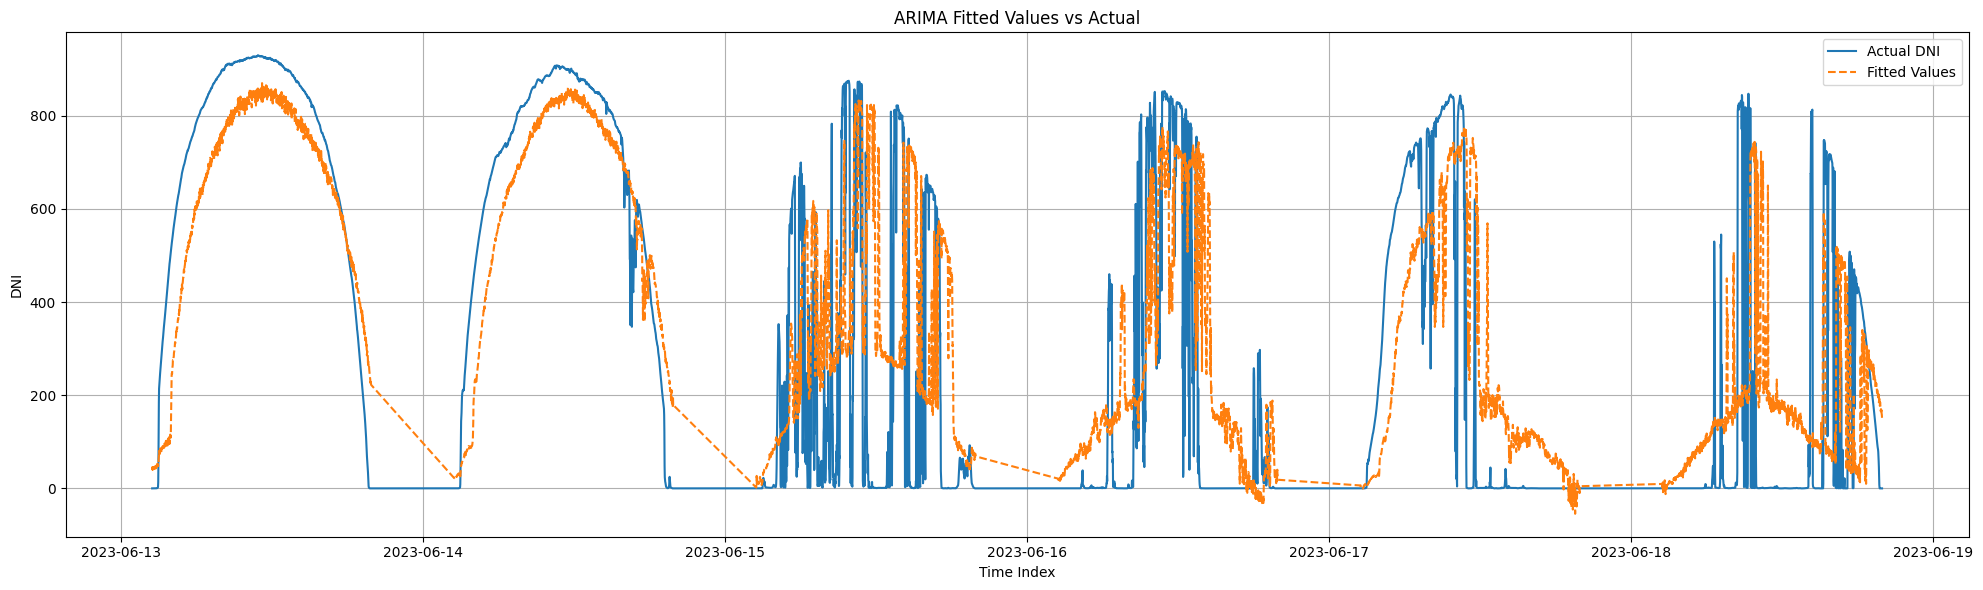

In [6]:
start = '2023-06-13'
end = '2023-06-18'
# Plot fitted values
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(df.loc[start:end].index, df.loc[start:end]['DNI'], label='Actual DNI')
plt.plot(df.loc[start:end].index, fitted_values.loc[start:end], label='Fitted Values', linestyle='--')
plt.title('ARIMA Fitted Values vs Actual')
plt.xlabel('Time Index')
plt.ylabel('DNI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()